In [5]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.base import clone

def plot_importances(columns,importances,figsize=None, ax=None, save=None):
    I = pd.DataFrame(data={'Feature':columns, 'Importance':importances})
    I = I.set_index('Feature')
    I = I.sort_values('Importance', ascending=True)
    I.plot(kind='barh', figsize=figsize, legend=False, ax=ax, fontsize=14)
    plt.tight_layout()
    if save:
        plt.savefig(save)
    plt.show()

In [6]:
df = pd.read_csv("data/rent.csv")
features = ['bathrooms','bedrooms','longitude','latitude',
            'price']
df = df[features].copy()
df['price'] = np.log(df['price'])
df.head(5)

,bathrooms,bedrooms,longitude,latitude,price
0,1.5,3,-73.9425,40.7145,8.006368
1,1.0,2,-73.9667,40.7947,8.606119
2,1.0,1,-74.0018,40.7388,7.955074
3,1.0,1,-73.9677,40.7539,8.094073
4,1.0,4,-73.9493,40.8241,8.116716


# Built-in scikit importances

0.875277638329


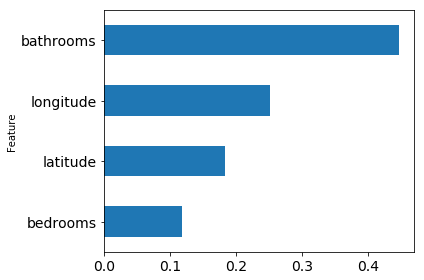

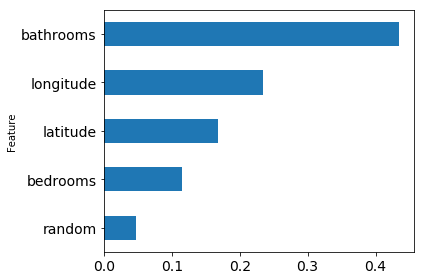

In [7]:
base_rf = RandomForestRegressor(n_estimators=100,
                                min_samples_leaf=1,
                                n_jobs=-1,
                                oob_score=True)

X_train, y_train = df.drop('price',axis=1), df['price']
rf = clone(base_rf)
rf.fit(X_train, y_train)
print(rf.oob_score_)

plot_importances(X_train.columns,rf.feature_importances_, save='regr_dflt.svg')

X_train2 = X_train.copy()
X_train2['random'] = np.random.random(size=len(X_train))
rf2 = clone(base_rf)
rf2.fit(X_train2, y_train)
plot_importances(X_train2.columns,rf2.feature_importances_, save='regr_dflt_random.svg')

## Examine cost of dropping columns

In [8]:
from sklearn.base import clone

# max_features=n_features for regressors but sqrt for classifiers

def regressor_dropping_importances(rf, X_train, y_train):
    rf_ = clone(rf)
    rf_.fit(X_train, y_train)
    oob = rf_.oob_score_
    print(f"oob R^2 score is {oob}")
    imp = []
    for col in X_train.columns:
        X = X_train.copy().drop(col, axis=1)
        rf_ = clone(rf)
        rf_.fit(X, y_train)
        o = rf_.oob_score_
        print(f"{col:10s}: R^2 score {oob:5.4f} - {o:5.4f} = {oob - o:5.4f}")
        imp.append(oob - o)
    return np.array(imp)

oob R^2 score is 0.8775214604519737
bathrooms : R^2 score 0.8775 - 0.8434 = 0.0341
bedrooms  : R^2 score 0.8775 - 0.7927 = 0.0848
longitude : R^2 score 0.8775 - 0.7435 = 0.1340
latitude  : R^2 score 0.8775 - 0.7504 = 0.1272


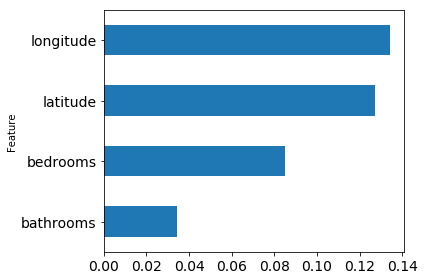

oob R^2 score is 0.8625564298742262
bathrooms : R^2 score 0.8626 - 0.8221 = 0.0405
bedrooms  : R^2 score 0.8626 - 0.7564 = 0.1062
longitude : R^2 score 0.8626 - 0.6949 = 0.1676
latitude  : R^2 score 0.8626 - 0.6977 = 0.1649
random    : R^2 score 0.8626 - 0.8775 = -0.0150


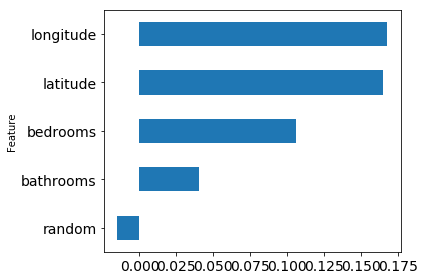

In [9]:
base_rf = RandomForestRegressor(n_estimators=100,
                                min_samples_leaf=1,
                                n_jobs=-1,
                                oob_score=True,
                                random_state = 999) # same boostrapping samples

X_train, y_train = df.drop('price',axis=1), df['price']
rf = clone(base_rf)

plot_importances(X_train.columns, 
                 regressor_dropping_importances(rf, X_train, y_train),
                 save='regr_dropcol.svg')

X_train, y_train = df.drop('price',axis=1), df['price']
X_train2 = X_train.copy()
X_train2['random'] = np.random.random(size=len(X_train))
rf2 = clone(base_rf)
plot_importances(X_train2.columns,
                 regressor_dropping_importances(rf2, X_train2, y_train),
                 save='regr_dropcol_random.svg')

# Roll your own OOB R^2 score

In [10]:
from sklearn.ensemble.forest import _generate_unsampled_indices
from sklearn.metrics import r2_score
import warnings

# TODO: add arg for subsample size to compute oob score

def oob_regression_r2_score(rf, X_train, y_train):
    X = X_train.values
    y = y_train.values

    n_samples = len(X)
    n_classes = len(np.unique(y))
    predictions = np.zeros(n_samples)
    n_predictions = np.zeros(n_samples)
    for tree in rf.estimators_:
        unsampled_indices = _generate_unsampled_indices(tree.random_state, n_samples)
        tree_preds = tree.predict(X[unsampled_indices, :])
        predictions[unsampled_indices] += tree_preds
        n_predictions[unsampled_indices] += 1

    if (n_predictions == 0).any():
        warnings.warn("Too few trees; some variables do not have OOB scores.")
        n_predictions[n_predictions == 0] = 1

    predictions /= n_predictions
    
    oob_score = r2_score(y, predictions)
    return oob_score

# Permutation importance

In [11]:
def regression_permutation_importances(rf, X_train, y_train):
    rf.fit(X_train, y_train)
    oob = rf.oob_score_
    imp = []
    for col in X_train.columns:
        save = X_train[col].copy()
        X_train[col] = np.random.permutation(X_train[col])
        o = oob_regression_r2_score(rf, X_train, y_train)
        X_train[col] = save
        print(f"{col:10s}: r2 score {oob:5.4f} - {o:5.4f} = {oob - o:5.4f}")
        imp.append(oob - o)
    return np.array(imp)

bathrooms : r2 score 0.8775 - 0.4559 = 0.4216
bedrooms  : r2 score 0.8775 - 0.3744 = 0.5031
longitude : r2 score 0.8775 - 0.3214 = 0.5561
latitude  : r2 score 0.8775 - 0.3923 = 0.4853


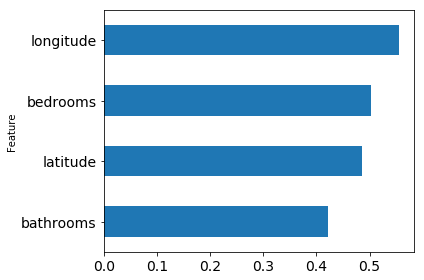

bathrooms : r2 score 0.8624 - 0.4519 = 0.4105
bedrooms  : r2 score 0.8624 - 0.3714 = 0.4910
longitude : r2 score 0.8624 - 0.3816 = 0.4807
latitude  : r2 score 0.8624 - 0.4551 = 0.4072
random    : r2 score 0.8624 - 0.8630 = -0.0006


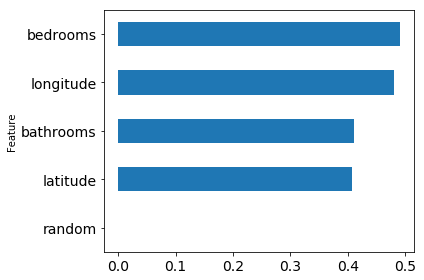

In [12]:
X_train, y_train = df.drop('price',axis=1), df['price']

base_rf = RandomForestRegressor(n_estimators=100,
                                min_samples_leaf=1,
                                n_jobs=-1,
                                max_features=len(X_train.columns),
                                oob_score=True,
                                random_state = 999) # same boostrapping samples

rf = clone(base_rf)
rf.fit(X_train, y_train)
plot_importances(X_train.columns,
                 regression_permutation_importances(rf, X_train, y_train),
                 save='regr_permute.svg')

X_train2 = X_train.copy()
X_train2['random'] = np.random.random(size=len(X_train))
rf2 = clone(base_rf)
rf2.fit(X_train2, y_train)

plot_importances(X_train2.columns,
                 regression_permutation_importances(rf2, X_train2, y_train),
                 save='regr_permute_random.svg')